In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from dataloader import get_dataloader
import os
import pandas as pd

test_root_path = "maize_dataset_split/test"
test_csv_file_path = "maize_dataset_split/test.csv"
img_size = (224, 224)
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights_path = "weights_resnet18/best_model.pt"

label_mapping = {
    "Blight": 0,
    "Common_Rust": 1,
    "Gray_Leaf_Spot": 2,
    "Healthy": 3
}

reverse_mapping = {
    0 : "Blight",
    1 : "Common_Rust",
    2 : "Gray_Leaf_Spot",
    3 : "Healthy"
}

transform_pipeline_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std  = [0.229, 0.224, 0.225]),
    ])

test_loader = get_dataloader(
    root_path=test_root_path,
    label_mapping=label_mapping,
    img_size=img_size,
    csv_file_path=test_csv_file_path,
    transforms=transform_pipeline_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [2]:
import torchvision.models as models
import torch.nn as nn
import torch

print(torch.cuda.is_available())

# Training entire model with imagenet weights
def get_resnet18_model(num_classes, weights=None):
    model = models.resnet18(weights= weights)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model
weights_path = "weights_resnet18/best_model.pt"
model_pt_11m = get_resnet18_model(num_classes=4)
model_pt_11m.load_state_dict(state_dict=torch.load(weights_path)['model_state_dict'],strict=True)
model_pt_11m.eval()

# Training Model From Scratch
def get_resnet18_model(num_classes, weights=None):
    model = models.resnet18(weights=weights)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model
weights_path = "weights_resnet18_scratch/best_model.pt"
model_from_scratch = get_resnet18_model(num_classes=4)
model_from_scratch.load_state_dict(state_dict=torch.load(weights_path)['model_state_dict'],strict=True)
model_from_scratch.eval()

# Training Model with ImageNEt weights and layer 4 and fc in trainable
def get_resnet18_model(num_classes, weights=None):
    model = models.resnet18(weights=weights)    
    for params in model.parameters():
        params.requires_grad_(False)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes).requires_grad_(True)
    model.layer4.requires_grad_(True)
    return model
weights_path = "weights_resnet18_fc_only/best_model.pt"
model_pt_8m = get_resnet18_model(num_classes=4)
model_pt_8m.load_state_dict(state_dict=torch.load(weights_path)['model_state_dict'],strict=True)
model_pt_8m.eval()


True


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

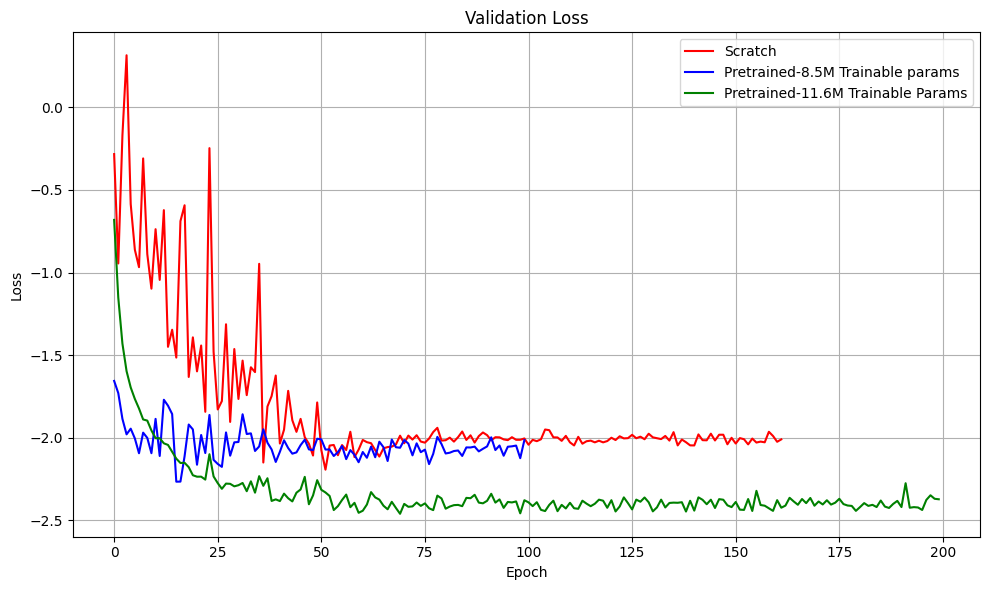

Minimum Val loss : 0.11162530360743403 | Model : Scratch
Minimum Val loss : 0.10381745081394911 | Model : Pretrained-8.5M Trainable params
Minimum Val loss : 0.08548261751420796 | Model : Pretrained-11.6M Trainable Params


In [3]:
import re
import matplotlib.pyplot as plt
import numpy as np

log_file_paths = ['weights_resnet18_scratch/resnet_scratch.log',
                  'weights_resnet18_fc_only/resnet18_fc_only.log',
                  'weights_resnet18/training_logs_resnet18.log']  

colours = ["red","blue","green"]
labels = ["Scratch","Pretrained-8.5M Trainable params","Pretrained-11.6M Trainable Params"]

validation_losses_list = []
min_val_loss_list = []
val_pattern = re.compile(r'Validation Loss ([0-9.]+) at')

for log_file_path in log_file_paths:
    min_val_loss = 10
    validation_losses = []
    with open(log_file_path, 'r') as f:
        for line in f:
            val_match = val_pattern.search(line)
            if val_match:
                val_loss = float(val_match.group(1))
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                validation_losses.append(np.log(val_loss))
    validation_losses_list.append(validation_losses)
    min_val_loss_list.append(min_val_loss)


plt.figure(figsize=(10, 6))
for i in range(len(validation_losses_list)):
    plt.plot(np.arange(0,len(validation_losses_list[i])),validation_losses_list[i],color=colours[i],label=labels[i])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for i in range(len(min_val_loss_list)):
    print(f"Minimum Val loss : {min_val_loss_list[i]} | Model : {labels[i]}")

In [4]:
models = [model_from_scratch,model_pt_8m,model_pt_11m]
model_names = ["Scratch","Pretrained-8.5M Trainable params","Pretrained-11.6M Trainable Params"]

for i,model in enumerate(models):

    model = model.to("cuda")
    correct = 0
    total = 0

    image_names_list= []
    prediction = []
    with torch.no_grad():
        for images, labels, image_name in test_loader:
            image_names_list.extend(list(image_name))
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            pred = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            for p in pred:
                prediction.append(reverse_mapping[int(p)])

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}% | Label : {model_names[i]}")                                                             

Test Accuracy: 95.23% | Label : Scratch
Test Accuracy: 95.55% | Label : Pretrained-8.5M Trainable params
Test Accuracy: 96.03% | Label : Pretrained-11.6M Trainable Params


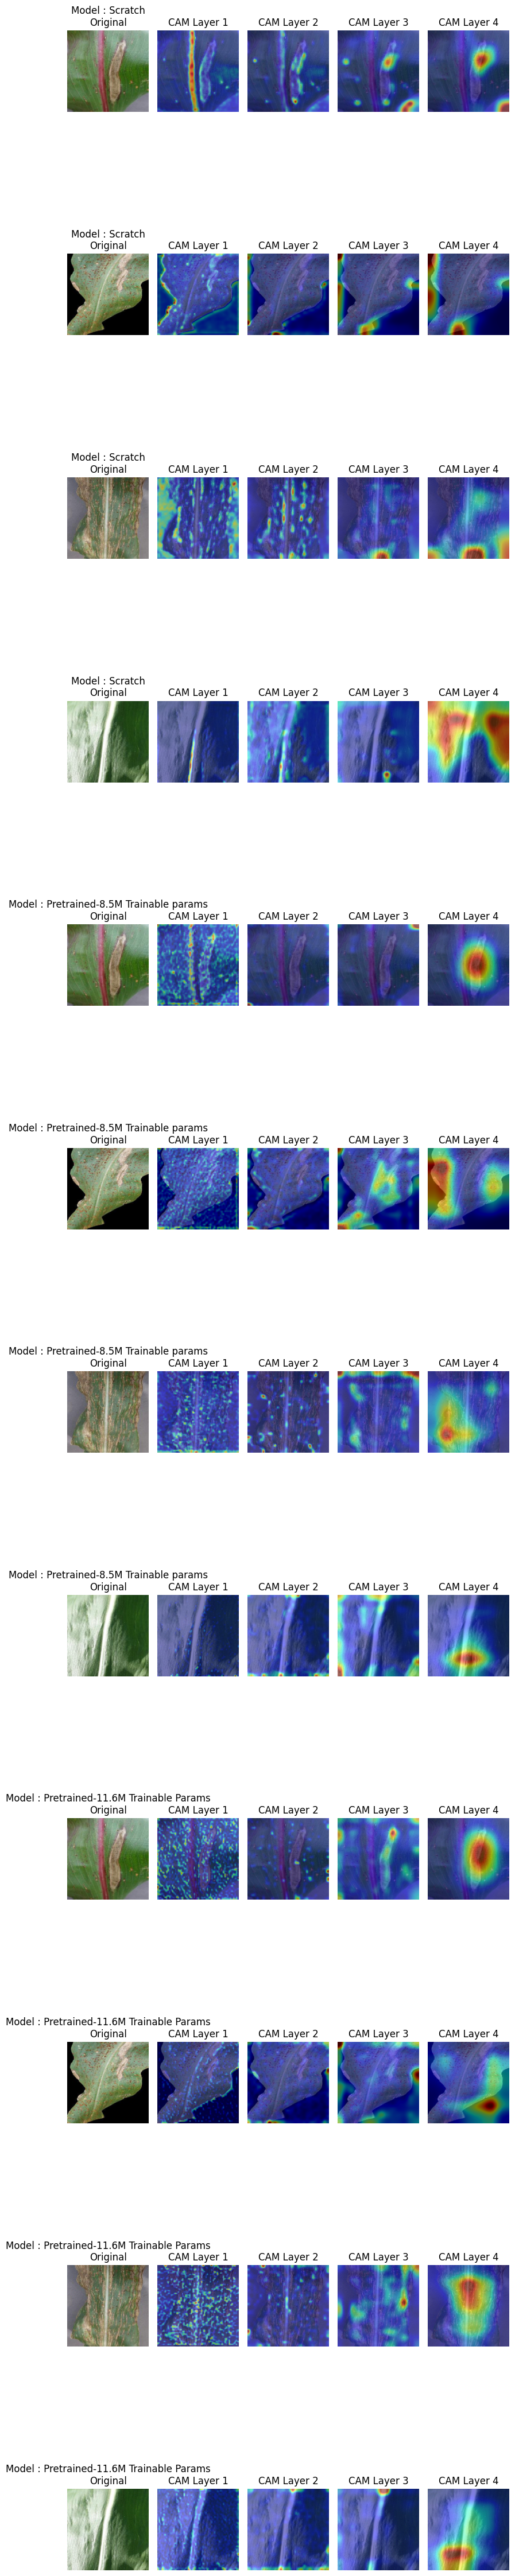

In [5]:
# Define your model
from PIL import Image
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
  
from torchcam.methods import SmoothGradCAMpp

models = [model_from_scratch,model_pt_8m,model_pt_11m]
model_names = ["Scratch","Pretrained-8.5M Trainable params","Pretrained-11.6M Trainable Params"]

img_paths = ["maize_dataset_split/test/Blight/Blight_00034.jpg",
             "maize_dataset_split/test/Common_Rust/Common_Rust_00068.jpg",
             "maize_dataset_split/test/Gray_Leaf_Spot/Gray_Leaf_Spot_00320.jpg",
             "maize_dataset_split/test/Healthy/Healthy_00119.jpg"]

num_images = len(img_paths) * len(models)
cols = 5  # One for original, one for CAM overlay
rows = num_images

fig, axes = plt.subplots(rows, cols, figsize=(8, 4 * rows))

if rows == 1:  # Edge case for a single image
    axes = [axes]

transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std  = [0.229, 0.224, 0.225]),
])

for k,model in enumerate(models):
    model = model.to("cpu")
    model.requires_grad_(True)
    
    target_layers = [model.layer1[-1],model.layer2[-1],model.layer3[-1],model.layer4[-1]]

    with SmoothGradCAMpp(model,target_layer=target_layers) as cam_extractor:
        for i, img_path in enumerate(img_paths):
            image = Image.open(img_path).convert("RGB")
            image_resized = image.resize((224, 224), Image.BILINEAR)
            input_tensor = transform_pipeline(image_resized)

            # Forward pass
            out = model(input_tensor.unsqueeze(0))
            class_idx = out.squeeze(0).argmax().item()

            # Get CAM
            activation_maps = cam_extractor(class_idx, out)
            
            # Plot original image
            i = i + k*len(img_paths)
            axes[i][0].imshow(image_resized)
            axes[i][0].axis('off')
            axes[i][0].set_title(f"Model : {model_names[k]}\nOriginal")

            # Plot CAM overlays from each layer
            for j in range(4):
                cam_img = overlay_mask(
                    image_resized,
                    to_pil_image(activation_maps[j].squeeze(0), mode='F'),
                    alpha=0.5
                )
                axes[i][j + 1].imshow(cam_img)
                axes[i][j + 1].axis('off')
                axes[i][j + 1].set_title(f"CAM Layer {j+1}")

plt.tight_layout()
plt.show()
